<a href="https://colab.research.google.com/github/francescobellina/Repo_laboratorio_BiophotonicsI/blob/main/Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

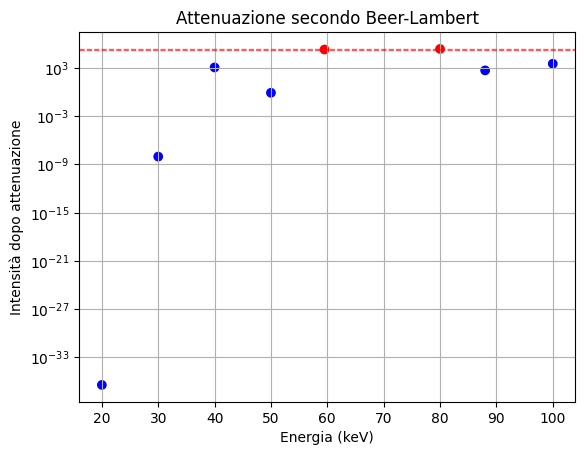

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def beer_lambert(intensita0, coefficiente_massico, densita, x):
    mu = coefficiente_massico * densita
    return intensita0 * np.exp(-mu * x)

# Dati
energie = np.array([20, 30, 40, 50, 59.5, 80, 88, 100])
intensita0 = np.array([1.2, 7.89, 10.5, 9.5, 58.2, 3.6, 3.0, 1.8]) * 1e6
coefficiente_massico = np.array([86.36, 30.32, 8.04, 14.36, 5.021, 2.419, 7.68, 5.549])
densita = 11.34  # g/cm^3 (per il piombo)
x = 0.1  # spessore in cm

# Calcolo intensità dopo attenuazione
intensita_dopo = beer_lambert(intensita0, coefficiente_massico, densita, x)

# Trova gli indici dei due valori più alti di intensità
top_two_indices = intensita_dopo.argsort()[-2:]

# Crea un array di colori blu di default
colors = ['blue'] * len(intensita_dopo)

# Colora di rosso i due punti più alti
for idx in top_two_indices:
    colors[idx] = 'red'

# Grafico
plt.figure()
plt.scatter(energie, intensita_dopo, color=colors)
plt.xlabel("Energia (keV)")
plt.ylabel("Intensità dopo attenuazione")
plt.title("Attenuazione secondo Beer-Lambert")
plt.yscale("log")
plt.grid(True)

# Aggiunge linee orizzontali rosse leggermente tratteggiate sui due punti più alti
for idx in top_two_indices:
    plt.axhline(y=intensita_dopo[idx], color='red', linestyle='--', linewidth=1, alpha=0.6)

plt.show()


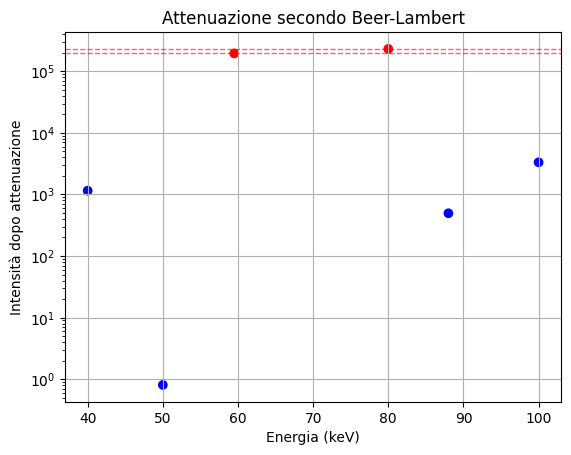

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def beer_lambert(intensita0, coefficiente_massico, densita, x):
    mu = coefficiente_massico * densita
    return intensita0 * np.exp(-mu * x)

# Dati
energie = np.array([40, 50, 59.5, 80, 88, 100])
intensita0 = np.array([ 10.5, 9.5, 58.2, 3.6, 3.0, 1.8]) * 1e6
coefficiente_massico = np.array([8.04, 14.36, 5.021, 2.419, 7.68, 5.549])
densita = 11.34  # g/cm^3 (per il piombo)
x = 0.1  # spessore in cm

# Calcolo intensità dopo attenuazione
intensita_dopo = beer_lambert(intensita0, coefficiente_massico, densita, x)

# Trova gli indici dei due valori più alti di intensità
top_two_indices = intensita_dopo.argsort()[-2:]

# Crea un array di colori blu di default
colors = ['blue'] * len(intensita_dopo)

# Colora di rosso i due punti più alti
for idx in top_two_indices:
    colors[idx] = 'red'

# Grafico
plt.figure()
plt.scatter(energie, intensita_dopo, color=colors)
plt.xlabel("Energia (keV)")
plt.ylabel("Intensità dopo attenuazione")
plt.title("Attenuazione secondo Beer-Lambert")
plt.yscale("log")
plt.grid(True)

# Aggiunge linee orizzontali rosse leggermente tratteggiate sui due punti più alti
for idx in top_two_indices:
    plt.axhline(y=intensita_dopo[idx], color='red', linestyle='--', linewidth=1, alpha=0.6)

plt.show()


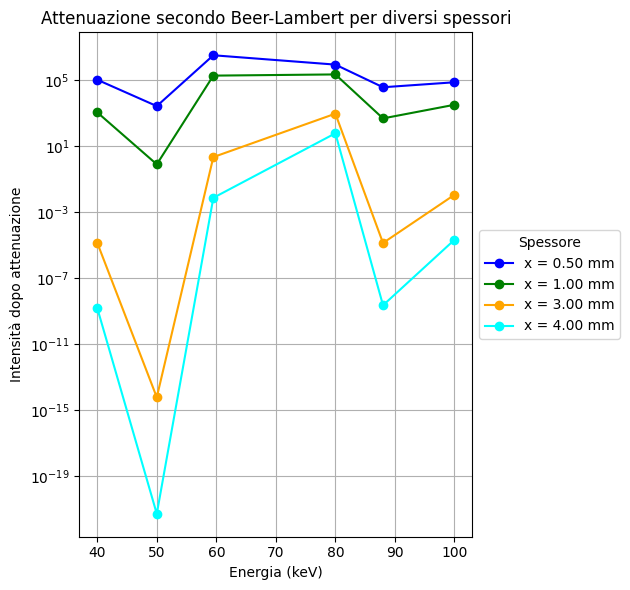

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def beer_lambert(intensita0, coefficiente_massico, densita, x):
    mu = coefficiente_massico * densita
    return intensita0 * np.exp(-mu * x)

# Dati
energie = np.array([40, 50, 59.5, 80, 88, 100])
intensita0 = np.array([10.5, 9.5, 58.2, 3.6, 3.0, 1.8]) * 1e6
coefficiente_massico = np.array([8.04, 14.36, 5.021, 2.419, 7.68, 5.549])
densita = 11.34  # g/cm^3 per il piombo

# Spessori in cm (convertiti da mm)
spessori_cm = [0.05, 0.1, 0.3, 0.4]

# Colori distinti per ogni spessore
colori = ['blue', 'green', 'orange', 'cyan']

plt.figure(figsize=(8,6))

# Per ogni spessore calcoliamo l'intensità attenuata e tracciamo le linee
for x, colore in zip(spessori_cm, colori):
    intensita_dopo = beer_lambert(intensita0, coefficiente_massico, densita, x)
    plt.plot(energie, intensita_dopo, color=colore, marker='o', linestyle='-', label=f'x = {x*10:.2f} mm')

plt.xlabel("Energia (keV)")
plt.ylabel("Intensità dopo attenuazione")
plt.title("Attenuazione secondo Beer-Lambert per diversi spessori")
plt.yscale("log")
plt.grid(True)
plt.legend(title="Spessore", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Lascia spazio per la legenda
plt.show()


#PATRICLE TRACKING AND DIFFUSION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("ciao")

ciao


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

file_path = '/content/drive/MyDrive/Experiment_spots_002.csv'

df = pd.read_csv(file_path, skiprows=3)
print("Nomi colonne effettive:", list(df.columns))

# Estrai le colonne delle coordinate (micron) in base all'ordine delle colonne
x_data = df['(micron)'].astype(float).values
y_data = df['(micron).1'].astype(float).values

# ---- Stampa ordinata delle prime 20 coordinate x/y ----
first20_df = pd.DataFrame({'X (micron)': x_data[:20], 'Y (micron)': y_data[:20]})
print("\nPrime 20 coordinate (x,y):")
print(first20_df)

# Se hai più tracce, ricostruisci traiettorie (qui presupponiamo Track ID in 'Unnamed: 1')
tracks = df['Unnamed: 1'].astype(str).values
frames = df['Unnamed: 9'] if 'Unnamed: 9' in df.columns else np.arange(len(x_data))

unique_tracks = np.unique(tracks)
num_frames = len(np.unique(frames))
x_trajs = np.zeros((len(unique_tracks), num_frames))
y_trajs = np.zeros((len(unique_tracks), num_frames))
for i, track in enumerate(unique_tracks):
    mask = tracks == track
    sort_idx = np.argsort(frames[mask])
    x_trajs[i, :] = x_data[mask][sort_idx]
    y_trajs[i, :] = y_data[mask][sort_idx]

# --- MSD analysis ---
def eaMSD(x_trajs, y_trajs, n):
    return np.nanmean((x_trajs[:, n] - x_trajs[:, 0])**2 + (y_trajs[:, n] - y_trajs[:, 0])**2)
def taMSD(x, y, n):
    disp = (x[n:] - x[:-n])**2 + (y[n:] - y[:-n])**2
    return np.nanmean(disp)
def msd_vs_time(x_trajs, y_trajs, max_lag):
    ea = [eaMSD(x_trajs, y_trajs, n) for n in range(1, max_lag)]
    ta = np.mean([[taMSD(x, y, n) for n in range(1, max_lag)] for x, y in zip(x_trajs, y_trajs)], axis=0)
    return ea, ta

M, N = x_trajs.shape
max_lag = min(N//2, N-1)
dt = 0.1
time = np.arange(N) * dt

ea, ta = msd_vs_time(x_trajs, y_trajs, max_lag)
lags = np.arange(1, max_lag) * dt

plt.figure()
plt.plot(lags, ea, label='Ensemble MSD')
plt.plot(lags, ta, label='Time-averaged MSD')
if len(ea) > 1:
    D_estimate = ea[1] / (4 * dt)
    plt.plot(lags, 4 * D_estimate * lags, '--', label=f'4Dt (theory, D~{D_estimate:.2f})')
plt.xlabel(r't (s)')
plt.ylabel(r'MSD ($\mu m^2$)')
plt.legend()
plt.title('Mean Square Displacement')
plt.show()

plt.figure()
for t_idx, t_col in zip([10, 20, 40, 80], ['b', 'r', 'g', 'c']):
    if t_idx < N:
        x_now = x_trajs[:, t_idx]
        mu, std = np.nanmean(x_now), np.nanstd(x_now)
        x_vals = np.linspace(mu - 4*std, mu + 4*std, 100)
        plt.plot(x_vals, norm.pdf(x_vals, mu, std), label=f't={time[t_idx]:.1f}s')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel('p(x,t)')
plt.title('Distribution of x at different times')
plt.legend()
plt.show()


Nomi colonne effettive: ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', '(quality)', '(micron)', '(micron).1', '(micron).2', '(sec)', 'Unnamed: 8', '(micron).3', 'Unnamed: 10', 'Unnamed: 11', '(counts)', '(counts).1', '(counts).2', '(counts).3', '(counts).4', '(counts).5', 'Unnamed: 18', 'Unnamed: 19']

Prime 20 coordinate (x,y):
    X (micron)  Y (micron)
0    10.469439   18.039649
1    10.308371   17.798047
2    10.066769   18.120183
3    10.630508   17.717513
4    10.469439   18.039649
5    10.952644   17.234308
6    10.711042   17.959115
7    10.791576   17.475910
8    11.194247   17.234308
9    11.435849   17.073240
10   11.435849   16.912171
11   11.516383   16.912171
12   12.080122   16.106830
13   12.160656   15.945761
14   12.241191   15.784693
15   12.482793   14.818283
16   12.402259   15.220954
17   12.965998   14.657215
18   13.288135   14.415613
19   13.288135   14.496147
